## Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

PCMCI is described here: J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

This tutorial explains how to apply the weighted least squares variant of the partial correrlation conditional independence test (ParCorrWLS). It is designed to deal with heteroskedasticity, i.e. non-constant variance of the error terms in a linear Gaussian setting. See the following paper for theoretical background: 

W. Günther, U. Ninad, J. Wahl, J. Runge, Conditional Independence Testing with Heteroskedastic Data and Applications to Causal Discovery, Advances in neural information processing systems 35 (2022)

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, ParCorrWLS

from scipy import stats

/home/jakobrunge/work/code/python_code/tigramite/tigramite_v4/tigramite/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: ('Version mismatch. Installed version of torch', '1.10.2', 'Please install torch>=', '1.11.0')
  warnings.warn(str(e))


## 1. Heteroskedasticity

One assumption that the well-known partial correlation test (ParCorr) rests on is homoskedasticity, meaning that the variance of the error term is constant. 
We are interested in the situation where this assumption is violated, i.e., we want to consider heteroskedastic data. In this case the variance can, for instance, depend on the sampling index or the value of one or multiple influencing variables. One may think of a linear dependence of the variance on one influencing variable. However the relationship can take many different functional forms.

ParCorr becomes unreliable on heteroskedastic data, since the covariance matrix of the ordinary least squares (OLS) estimator, which is used for calculating the test statistic, can be biased and inconsistent in this setting.

The sources for heteroskedasticity in real data are manifold. For example, in environmental sciences
precipitation in different areas might exhibit different variances that are unaccounted for by other
variables in the system, i.e. location-scaled noise. Such a problem could be introduced by aggregating
data of different catchments and not adding a variable that is well enough correlated with catchment
location. Seasonal effeccts can also introduce heteroskedasticity.

To model heteroskedasticity within a structural causal model (SCM), we represent it as a scaling function of the noise variable.
Consider finitely many random variables $V = (X^1, \ldots, X^d)$ with joint distribution $\mathcal{P}_X$ over a domain $\mathcal{X} = \mathcal{X}_1 \times \ldots \times \mathcal{X}_d$. Then we are interested in $n$ samples from the following SCM with assignments
\begin{align} \label{scm_hs}
X_t^i &:= f_i(Pa(X_t^i)) + h_i(H(X_t^i)) \cdot N_i, \qquad i = 1, \ldots, d
\end{align}
where $f_i$ are linear functions, $t \in \mathcal{T}$ stands for the sample index, and we have the heteroskedasticity functions $s_i: \mathcal{X} \times \mathcal{T} \xrightarrow{} \mathbf{R}_{\geq 0}$. The noise variables $N_i$ are assumed independent standard Gaussian distributions. The parent set of the variable $X_t^i$ is denoted by $Pa(X_t^i)$, and the set of heteroskedasticity-inducing variables is denotes by $H(X_t^i) \subset Pa(X_t^i) \cup \{t\}$ which can also be the empty set. Furthermore, we make the restriction that the causal relationships are stable over time, i.e. the parent sets $Pa(X_t^i)$ as well as the functions $f_i$ are not time-dependent.


## 2. ParCorrWLS: Conditional independence testing with heteroskedastic data
### 2.1 General idea
We have seen that the standard partial correlation test is sensitive to heteroskedastic noise since it
is based on an OLS regression step. Therefore, we propose to replace the OLS regression by the
weighted least squares (WLS) approach which is known to be able to handle non constant error
variance.

The idea of WLS is to perform a re-weighting of each data point depending on how far it is from the
true regression line. It is reasonable to assume data points where the error has low variance to be
more informative than those with high error variance. Therefore, ideally the weights are chosen as
the inverse variance of the associated error.

### 2.2 Variance function estimation
Generally, we cannot hope to know the grund truth variance, therefore we have to approximate the conditional variance function of the heteroskedastic variables. We illustrate the approach for a simplified version of the SCM above.
Namely, we consider
\begin{align}
X_t &= aZ + s(Z,t) \cdot N_X \\
Z_t &= N_Z
\end{align}
where $a$ is a constant, and $N_X$, and $N_Z$ are standard normal independent noise terms.

For $X$ we now approximate $s^2(z, t) = Var(X_t | Z=z)$. 

For that, we use a residual-based non-parametric estimator for the conditional variance, similar to the approach of [1].
Motivated by the identity $Var(X | Z) = \mathbb{E}[(X - \mathbb{E}[X | Z])^2 |Z]$, and noting that this is the regression of $(X-aZ)^2$ on $Z$, the first step is using OLS regression to obtain the squared residuals $(X - \hat{a} Z)^2$. Afterwards, we use a non-parametric regression method to regress these residuals on $Z$ and thereby predict the conditional mean by using a linear combination of the $k$ residuals closest in $Z$ value. For sampling index-dependent heteroskedasticity this turns into a windowing approach, which essentially smoothes the squared residuals.

Note that we rely on the knowledge of the source of heteroskedasticity (in this case $Z$). This is expert knowledge that the user has to supply.

## 3. Application Example
### 3.1 Parent-dependent heteroskedasticity
#### 3.1.1 Toy data generation
Consider time series data generated according to the following process
$$
X_t = 0.7 Z_{t-1} + \eta^X_t \\
Y_t = 0.5 Z_{t-1} + \eta^Y_t \\
Z_t = \eta^Z_t
$$
where $\eta^Z_t \sim \mathcal{N}(0,1)$, but $\eta^X_t, \eta^Y_t \sim \mathcal{N}(0, \sigma(Z_{t-1}))$.
Note, that $X$ and $Y$ are both heteroskedastic. In other words, their variances are changing with the value of $Z$ at lag one. Since the variance depends on $Z$, we call this parent-dependent heteroskedasticity. Below, $\sigma(\cdot)$ is generated using the function `generate_parent_dependent_stds`. 

The case of time-dependent heteroskedasticity will be covered below.

In [2]:
random_state = np.random.RandomState(42)
T = 500
N = 3

def generate_data(generate_stds, random_state):
    data = np.zeros((T, N))
    Z = random_state.standard_normal(T+1)
    data[:, 2] = Z[1:]
    stds_matrix = np.ones((T,N))
    stds = generate_stds(Z, T)
    stds_matrix[:, 0] = stds
    stds_matrix[:, 1] = stds
    noise_X = random_state.normal(0, stds, T)
    noise_Y = random_state.normal(0, stds, T)
    data[:, 0] = 0.7*Z[:T] + noise_X
    data[:, 1] = 0.7*Z[:T] + noise_Y
    return data, stds_matrix, noise_X, noise_Y

def generate_parent_dependent_stds(Z, T):
    stds = np.ones(T) + 5*(1 + Z[:T])*(1+Z[:T]>0)
    return stds


data, stds_matrix, noise_X, noise_Y = generate_data(generate_parent_dependent_stds, random_state)

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X$', r'$Y$', r'$Z$']
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

First, we plot the time series. This can be done with the function `tp.plot_timeseries`.

#### 3.1.2 Plotting the time series and visualizing heteroskedasticity

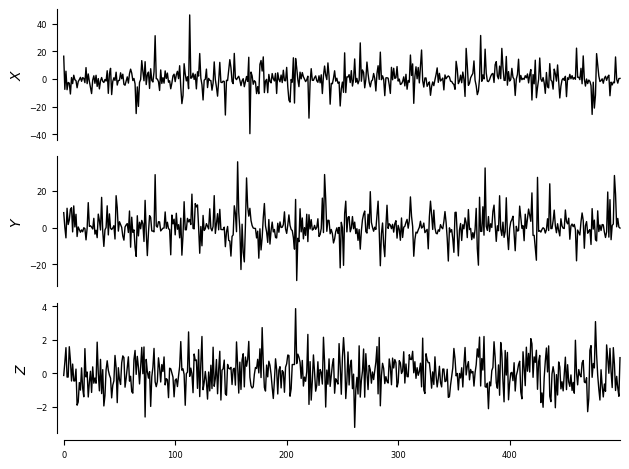

In [3]:
tp.plot_timeseries(dataframe); plt.show()

We also plot $\eta_X$ vs $Z$ and $\eta_Y$ vs $Z$ to visualize the heteroskedastic relationships.

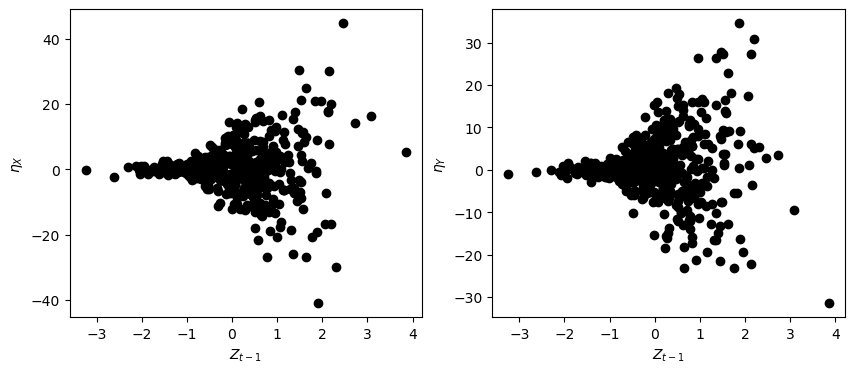

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

axs[0].scatter(data[:-1, 2], noise_X[1:], color="black")
axs[0].set_xlabel(r'$Z_{t-1}$')
axs[0].set_ylabel(r'$\eta_X$')

axs[1].scatter(data[:-1, 2], noise_Y[1:], color="black")
axs[1].set_xlabel(r'$Z_{t-1}$')
axs[1].set_ylabel(r'$\eta_Y$')

plt.show()

#### 3.1.3 The ParCorrWLS conditional independence test

To test the independence of $X$ and $Y$ given $Z$, we choose the conditional independence test `ParCorrWLS`. This test is suitable for testing linear dependencies in heteroskedastic data.

Since we don't know the variance function, we need to approximate it. In this case, `ParCorrWLS` requires us to provide expert knowledge on the heteroskedastic relationships in the form of a dictionary specifying which node has heteroskedastic noise with respect to which other node at which lag.

Furthermore, we can set the parameter `window_size` that handles how many neighbours are used for smoothing the squared residuals within the variance estimation step. See section 2.2 for details.

In [5]:
expert_knowledge = {0: [(2, -1)], 1: [(2, -1)]}

parcorr_wls = ParCorrWLS(expert_knowledge=expert_knowledge, 
                         window_size=50,
                         significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr_wls,
    verbosity=1)

In [6]:
pcmci.verbosity = 1
results = pcmci.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.01)
#results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr_wls
tau_min = 1
tau_max = 2
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X$ has 1 link(s):
        ($Y$ -1): max_pval = 0.00098, min_val = -0.148

    Variable $Y$ has 1 link(s):
        ($Z$ -1): max_pval = 0.00216, min_val =  0.137

    Variable $Z$ has 0 link(s):

##
## Step 2: PC algorithm with contemp. conditions and MCI tests
##

Parameters:

independence test = par_corr_wls
tau_min = 0
tau_max = 2
pc_alpha = 0.01
contemp_collider_rule = majority
conflict_resolution = True
reset_lagged_links = False
max_conds_dim = None
max_conds_py = None
max_conds_px = None
max_conds_px_lagged = None
fdr_method = none

## Significant links at alpha = 0.01:

    Variable $X$ has 0 link(s):

    Variable $Y$ has 1 link(s):
        ($Z$ -1): pval = 0.00216 | val =  0.137

    Variable $Z$ has 0 link(s):


Now we use `tp.plot_graph` to plot the learned DAG. Note that we indeed discovered the correct graph.

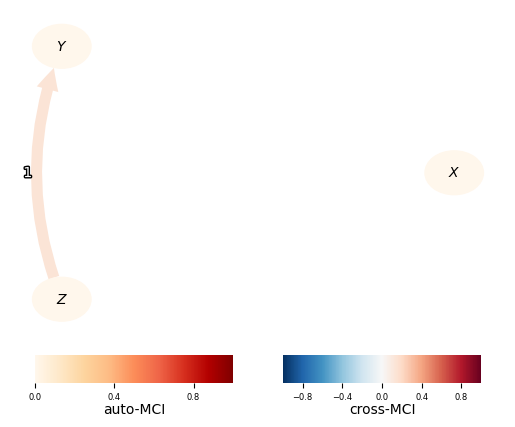

In [7]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

#### 3.1.4 Comparing to ParCorrWLS with ground truth weights

It is also possible to supply the ground truth variance for each observation to `ParCorrWLS` using the parameter `gt_std_matrix` instead of approximating the variance based on expert knowledge. However, note, generally such knowledge is hard to obtain and probably is only known for toy-data.

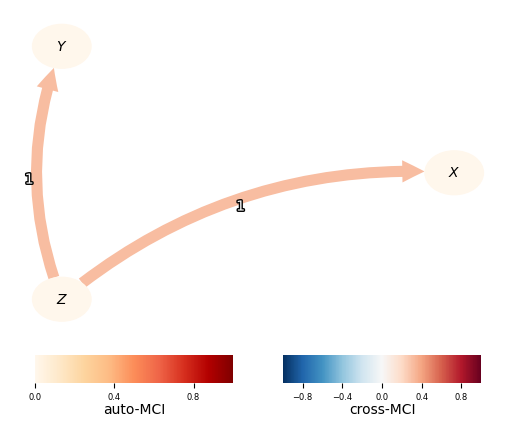

In [8]:
parcorr_wls_gt = ParCorrWLS(gt_std_matrix=stds_matrix,
                            significance='analytic')

pcmci_gt = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr_wls_gt,
    verbosity=0)
pcmci_gt.verbosity = 0
results_gt = pcmci_gt.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.01)

tp.plot_graph(
    val_matrix=results_gt['val_matrix'],
    graph=results_gt['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

#### 3.1.5 Comparison with ParCorr

To get an intuition for the usefulness of ParCorrWLS, we compare its output to that of the standard ParCorr conditional independence test.

In [9]:
parcorr = ParCorr(significance='analytic')
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

pcmci_parcorr.verbosity = 0
results_parcorr = pcmci_parcorr.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.01)

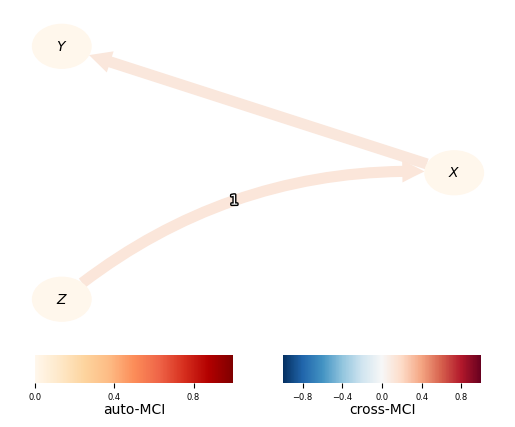

In [10]:
tp.plot_graph(
    val_matrix=results_parcorr['val_matrix'],
    graph=results_parcorr['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

We see that the standard partial correlation test is not able to recover the link between $Z$ and $Y$. It even finds a wrong link from $X$ to $Y$.

### 3.2 Time (or sampling index) -dependent heteroskedasticity

Consider again the following process from which we are generating our data
$$
X_t = 0.7 Z_{t-1} + \eta^X_t \\
Y_t = 0.5 Z_{t-1} + \eta^Y_t \\
Z_t = \eta^Z_t
$$
where $\eta^Z_t \sim \mathcal{N}(0,1)$, but $\eta^X_t, \eta^Y_t \sim \mathcal{N}(0, \sigma(t))$.
Note again, that $X$ and $Y$ are both heteroskedastic but this time with respect to $t$, i.e. the time or sampling index. In our code, $\sigma(\cdot)$ is generated using the function `generate_time_dependent_stds`. 

In [11]:
random_state = np.random.RandomState(42)

def generate_time_dependent_stds(Z, T):
    stds = np.array([1 + 0.018*t for t in range(T)])
    return stds

data, stds_matrix, noise_X, noise_Y = generate_data(generate_time_dependent_stds, random_state)

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X$', r'$Y$', r'$Z$']
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

Again, as above, we plot the time series using the function `tp.plot_timeseries`.

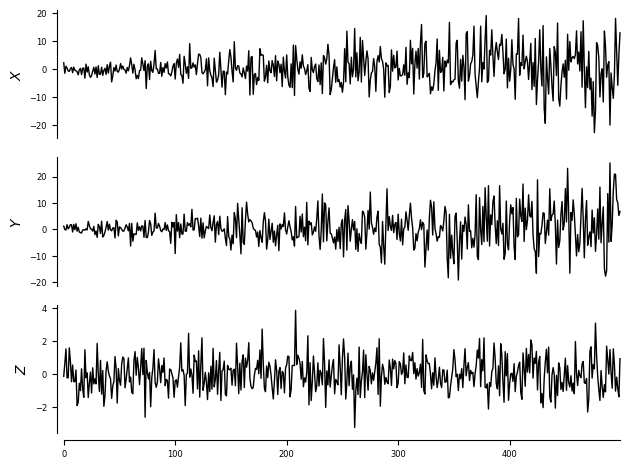

In [12]:
tp.plot_timeseries(dataframe); plt.show()

Here, we already can suspect heteroskedasticity from the timeseries plot. However, we also plot $\eta_X$ and $\eta_Y$ along the time axis to make sure that the heteroskedasticity isn't due to the parent.

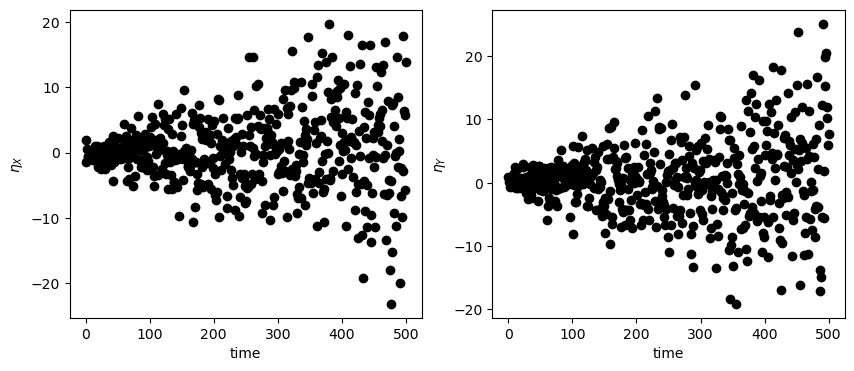

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

axs[0].scatter(np.linspace(0, T, T), noise_X, color="black")
axs[0].set_xlabel('time')
axs[0].set_ylabel(r'$\eta_X$')

axs[1].scatter(np.linspace(0, T, T), noise_Y, color="black")
axs[1].set_xlabel('time')
axs[1].set_ylabel(r'$\eta_Y$')

plt.show()

If we deal with time-dependent heteroskedasticity in our data, we again choose the conditional independence test `ParCorrWLS` to test the independence of $X$ and $Y$ given $Z$.
The expert knowledge of time-dependent heteroskedasticity can be passed to `ParCorrWLS` in a similar way as done above for parent-dependent heteroskedasticity. If we want to specify that all variables are affected by time-dependent heteroskedasticity, we can pass the string `'time-dependent heteroskedasticity'` to the `expert_knowledge` parameter of `ParCorrWLS`. However, it is also possible to specify for each node individually where its heteroskedasticity comes from. In this case we use a dictionary with the key being the node index and its item being the list with one element: `['time-dependent heteroskedasticity']`.
Again, we also set the `window_size` parameter.

In [14]:
expert_knowledge = {0: ["time-dependent heteroskedasticity"], 1: ["time-dependent heteroskedasticity"]}

parcorr_wls = ParCorrWLS(expert_knowledge=expert_knowledge, 
                         window_size=50,
                         significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr_wls,
    verbosity=1)

In [15]:
pcmci.verbosity = 1
results = pcmci.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr_wls
tau_min = 1
tau_max = 2
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X$ has 1 link(s):
        ($Z$ -1): max_pval = 0.00019, min_val =  0.167

    Variable $Y$ has 1 link(s):
        ($Z$ -1): max_pval = 0.00002, min_val =  0.188

    Variable $Z$ has 0 link(s):

##
## Step 2: PC algorithm with contemp. conditions and MCI tests
##

Parameters:

independence test = par_corr_wls
tau_min = 0
tau_max = 2
pc_alpha = 0.01
contemp_collider_rule = majority
conflict_resolution = True
reset_lagged_links = False
max_conds_dim = None
max_conds_py = None
max_conds_px = None
max_conds_px_lagged = None
fdr_method = none

## Significant links at alpha = 0.01:

    Variable $X$ has 1 link(s):
        ($Z$ -1): pval = 0.00019 | val =  0.167

    Variable $Y$ has 1 link(s):
        ($Z$ -1): pval = 0.00002 | val =  0.188

    Variabl

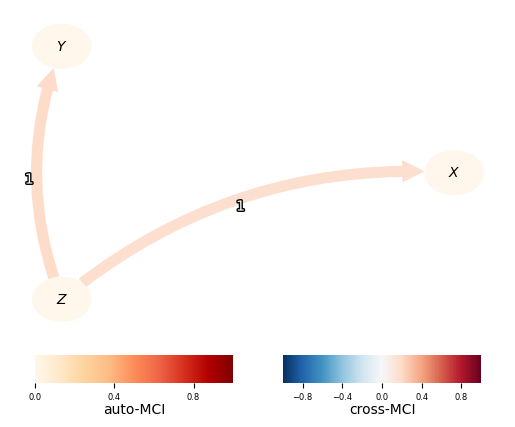

In [16]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

#### Comparison with ParCorrOLS

In the time-dependent heteroskedasticity case, we also expect degraded performance of the standard ParCorr test. This is also what we see in the plot below, the link from $Z$ to $X$ is not discovered.

In [17]:
parcorr = ParCorr(significance='analytic')
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

pcmci_parcorr.verbosity = 0
results_parcorr = pcmci_parcorr.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=0.01)

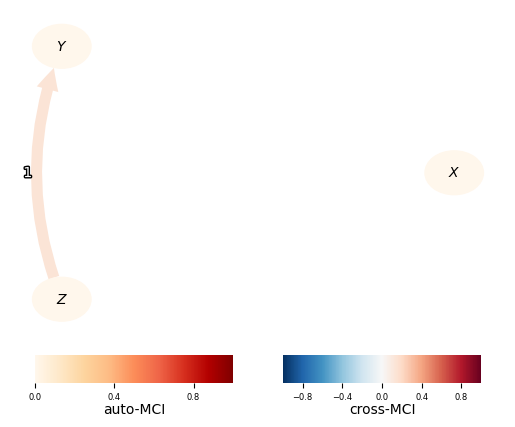

In [18]:
tp.plot_graph(
    val_matrix=results_parcorr['val_matrix'],
    graph=results_parcorr['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

##### References

[1] P. M. Robinson. Asymptotically efficient estimation in the presence of heteroskedasticity of unknown form.
Econometrica: Journal of the Econometric Society, pages 875–891, 1987.